In [1]:
from __future__ import print_function 
import numpy as np
import torch
import torch.autograd as ag
from matplotlib import pyplot
import torch.nn as nn
import torch.nn.functional as F
from math import exp
import matplotlib as pyplot 
import torchvision
import torchvision.transforms as transforms

#########################Load and reshape image###############################
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class generator(nn.Module):

    def __init__(self):
        super(generator, self).__init__()
        #ConvTranspose2d(input_channels,output_channels,kernel_size,stride,padding_value)
        #BatchNorm2d: Applies Batch Normalization over a 4d input that is seen as a mini-batch of 3d inputs
        
        self.deconv1 = nn.ConvTranspose2d(100, 128, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, 2, 1)

    #Weights initialized from a zero-centered normal distribution with standard deviation 0.02
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    
    
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        

In [3]:
G = generator()
D1 = discriminator()
D2 = discriminator()
D3 = discriminator()
D4 = discriminator()
D5 = discriminator()

if torch.cuda.is_available():
    G.cuda()
    D1.cuda()
    D2.cuda()
    D3.cuda()
    D4.cuda()
    D5.cuda()
    print ('USE GPU')


G.weight_init(mean=0.0, std=0.02)
D1.weight_init(mean=0.0, std=0.02)
D2.weight_init(mean=0.0, std=0.02)
D3.weight_init(mean=0.0, std=0.02)
D4.weight_init(mean=0.0, std=0.02)
D5.weight_init(mean=0.0, std=0.02)
 
y_real = torch.ones(100)
y_fake = torch.zeros(100)
y_real = ag.Variable(y_real.cuda())
y_fake = ag.Variable(y_fake.cuda())   

USE GPU


In [4]:
criterion = nn.BCELoss()
T = 30               # Number of epochs
gamma = .00005         # Learning rate
rho = .5              # Momentum
      
G_optimizer = torch.optim.Adam(G.parameters(), lr=gamma, betas=(rho, 0.999))
D1_optimizer = torch.optim.Adam(D1.parameters(), lr=gamma, betas=(rho, 0.999))
D2_optimizer = torch.optim.Adam(D2.parameters(), lr=gamma, betas=(rho, 0.999))
D3_optimizer = torch.optim.Adam(D3.parameters(), lr=gamma, betas=(rho, 0.999))
D4_optimizer = torch.optim.Adam(D4.parameters(), lr=gamma, betas=(rho, 0.999))
D5_optimizer = torch.optim.Adam(D5.parameters(), lr=gamma, betas=(rho, 0.999))

#losses for plot
D_losses = []
G_losses = []


for epoch in range(T): 
    
    for i, data in enumerate(trainloader,0):
        inputs, labels = data
        

        inputs = ag.Variable(inputs.cuda(),requires_grad=True)
        labels = ag.Variable(labels.cuda(),requires_grad=True)
        D1.zero_grad()
        D2.zero_grad()
        D3.zero_grad()
        D4.zero_grad()
        D5.zero_grad()
        
        #real losses
        D1_result = D1(inputs).squeeze()              #Real data and losses
        D2_result = D2(inputs).squeeze()              
        D3_result = D3(inputs).squeeze()              
        D4_result = D4(inputs).squeeze()              
        D5_result = D5(inputs).squeeze()              

        D1_real_loss = criterion(D1_result, y_real)    #labels is a matrix with ones
        D2_real_loss = criterion(D2_result, y_real)    
        D3_real_loss = criterion(D3_result, y_real)    
        D4_real_loss = criterion(D4_result, y_real)    
        D5_real_loss = criterion(D5_result, y_real)    
            
        D_result_real = (D1_result + D2_result + D3_result + D4_result + D5_result)/5
        D_real_loss = (D1_real_loss + D2_real_loss + D3_real_loss + D4_real_loss + D5_real_loss)/5
            
            
        #fake losses    
        z_ = torch.randn((100, 100)).view(-1, 100, 1, 1)    
        z_ = ag.Variable(z_.cuda())
        G_result = G(z_)                            #Generated images by G from noises
        
        D1_result = D1(G_result).squeeze()
        D2_result = D2(G_result).squeeze()
        D3_result = D3(G_result).squeeze()
        D4_result = D4(G_result).squeeze()
        D5_result = D5(G_result).squeeze()
        
        D1_fake_loss = criterion(D1_result, y_fake)
        D2_fake_loss = criterion(D2_result, y_fake)
        D3_fake_loss = criterion(D3_result, y_fake)
        D4_fake_loss = criterion(D4_result, y_fake)
        D5_fake_loss = criterion(D5_result, y_fake)
        
        D_result_fake = (D1_result + D2_result + D3_result + D4_result + D5_result)/5
        D_fake_loss = (D1_fake_loss + D2_fake_loss + D3_fake_loss + D4_fake_loss + D5_fake_loss)/5
        
        #backpropagate the error
        D1_loss = D1_real_loss + D1_fake_loss
        D1_loss.backward(retain_graph=True)
        D1_optimizer.step()
        
        D2_loss = D2_real_loss + D2_fake_loss
        D2_loss.backward(retain_graph=True)
        D2_optimizer.step()
        
        D3_loss = D3_real_loss + D3_fake_loss
        D3_loss.backward(retain_graph=True)
        D3_optimizer.step()
        
        D4_loss = D4_real_loss + D4_fake_loss
        D4_loss.backward(retain_graph=True)
        D4_optimizer.step()
        
        D5_loss = D5_real_loss + D5_fake_loss
        D5_loss.backward(retain_graph=True)
        D5_optimizer.step()
       
        D_total_loss = D_real_loss + D_fake_loss
        D_losses.append(D_total_loss.data[0])
        

        #D_fake_score = D_result.data.mean()
            
        
            
        # train generator G
        G.zero_grad()

        z_ = torch.randn((100, 100)).view(-1, 100, 1, 1)
        z_ = ag.Variable(z_.cuda())
        G_result = G(z_)     #fake image     
        
        D1_result = D1(G_result).squeeze()
        D2_result = D2(G_result).squeeze()
        D3_result = D3(G_result).squeeze()
        D4_result = D4(G_result).squeeze()
        D5_result = D5(G_result).squeeze()
        
        D_result = (D1_result + D2_result + D3_result + D4_result + D5_result)/5
        
        G_total_loss = criterion(D_result, y_real)
        G_total_loss.backward(retain_graph=True)
        G_optimizer.step()
        
        G_losses.append(G_total_loss.data[0])
    
        if i % 250 == 0:
            print('[%d/%d], loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), T, D_total_loss.data[0],
                                                              G_total_loss.data[0]) )

[1/30], loss_d: 1.443, loss_g: 0.709
[1/30], loss_d: 0.076, loss_g: 3.854
[2/30], loss_d: 0.034, loss_g: 4.296
[2/30], loss_d: 0.069, loss_g: 3.841
[3/30], loss_d: 0.073, loss_g: 4.393
[3/30], loss_d: 0.210, loss_g: 3.373
[4/30], loss_d: 0.183, loss_g: 3.147
[4/30], loss_d: 0.287, loss_g: 3.071
[5/30], loss_d: 0.499, loss_g: 2.681
[5/30], loss_d: 0.526, loss_g: 2.412
[6/30], loss_d: 0.298, loss_g: 2.403
[6/30], loss_d: 0.436, loss_g: 1.789
[7/30], loss_d: 0.365, loss_g: 2.112
[7/30], loss_d: 0.309, loss_g: 2.341
[8/30], loss_d: 0.328, loss_g: 2.193
[8/30], loss_d: 0.365, loss_g: 2.451
[9/30], loss_d: 0.318, loss_g: 2.309
[9/30], loss_d: 0.293, loss_g: 2.555
[10/30], loss_d: 0.351, loss_g: 2.165
[10/30], loss_d: 0.276, loss_g: 2.564
[11/30], loss_d: 0.293, loss_g: 2.094
[11/30], loss_d: 0.273, loss_g: 2.241
[12/30], loss_d: 0.311, loss_g: 2.516
[12/30], loss_d: 0.328, loss_g: 2.354
[13/30], loss_d: 0.332, loss_g: 2.328
[13/30], loss_d: 0.273, loss_g: 2.273
[14/30], loss_d: 0.282, loss_g

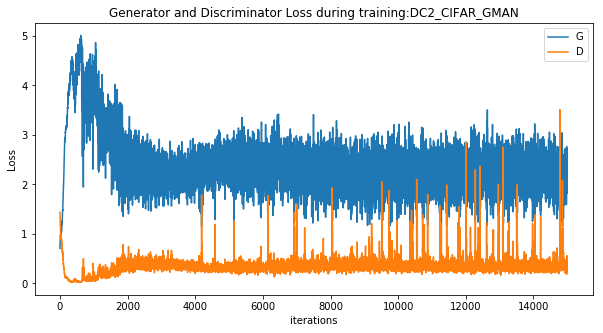

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title('Generator and Discriminator Loss during training:DC2_CIFAR_GMAN')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()  

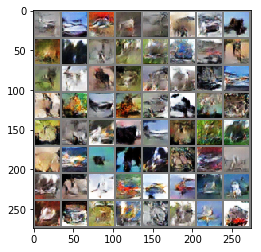

In [6]:
z_ = torch.randn((64,100)).view(-1, 100, 1, 1)

z_ = ag.Variable(z_.cuda(), volatile=True)
test_images = G(z_).cpu()
test_images = test_images.data.numpy()
test_images = test_images.squeeze()
test_images = torch.from_numpy(test_images).float()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(torchvision.utils.make_grid(test_images,8))

In [7]:
torch.save(G.state_dict(), 'DC1_CIFAR_MnetG.pt')
torch.save(D1.state_dict(), 'DC1_CIFAR_netD1.pt')
torch.save(D2.state_dict(), 'DC1_CIFAR_netD2.pt')
torch.save(D3.state_dict(), 'DC1_CIFAR_netD3.pt')
torch.save(D4.state_dict(), 'DC1_CIFAR_netD4.pt')
torch.save(D5.state_dict(), 'DC1_CIFAR_netD5.pt')

In [9]:
MnetG = generator()
MnetG.load_state_dict(torch.load('DC1_CIFAR_MnetG.pt'))
MnetG.eval()
MnetG.cuda()

netD1 = discriminator()
netD1.load_state_dict(torch.load('DC1_CIFAR_netD1.pt'))
netD1.eval()
netD1.cuda()

netD2 = discriminator()
netD2.load_state_dict(torch.load('DC1_CIFAR_netD2.pt'))
netD2.eval()
netD2.cuda()

netD3 = discriminator()
netD3.load_state_dict(torch.load('DC1_CIFAR_netD3.pt'))
netD3.eval()
netD3.cuda()

netD4 = discriminator()
netD4.load_state_dict(torch.load('DC1_CIFAR_netD4.pt'))
netD4.eval()
netD4.cuda()

netD5 = discriminator()
netD5.load_state_dict(torch.load('DC1_CIFAR_netD5.pt'))
netD5.eval()
netD5.cuda()


discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [10]:
tempD = []
Dloss = []
for epoch in range(10):
    for i, data in enumerate(testloader, 0):
        realImg = ag.Variable(data[0].cuda())
        batchSize = realImg.size(0)
        realLabel = torch.ones(100)
        realLabel = realLabel.cuda()
        output1 = netD1(realImg).view(-1)
        output2 = netD2(realImg).view(-1)
        output3 = netD3(realImg).view(-1)
        output4 = netD4(realImg).view(-1)
        output5 = netD5(realImg).view(-1)
        output = (output1 + output2 + output3 + output4 + output5)/5
        D_x = output.mean().data
        tempD.append(D_x)
    av_d = sum(tempD)/len(tempD)
    Dloss.append(av_d)
D2_test = sum(Dloss)/len(Dloss)

print(D2_test)


 0.5824
[torch.cuda.FloatTensor of size 1 (GPU 0)]

